In [2]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Project level imports
from larval_gonad.notebook import Nb

In [4]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force')

last updated: 2018-10-19 
Git hash: 824444dae7e5dbacf5d66394a4af0a940b2d487f


In [88]:
chroms = nbconfig.fbgn2chrom
clusters = nbconfig.seurat.get_clusters('res.0.6')
raw = pd.read_parquet('../scrnaseq-wf/data/raw.parquet')

In [99]:
def gt_zero(x):
    return sum(x > 0)

def calc_ratios(cluster_name):
    cluster = clusters[clusters.map(nbconfig.cluster_annot) == cluster_name].index.tolist()
    agg = raw.reindex(cluster, axis=1).join(chroms).groupby('chrom').agg([sum, gt_zero, len])

    res = agg.reset_index().melt(id_vars='chrom')
    res = res.pivot_table(index=['chrom', 'variable_0'], columns='variable_1', values='value', aggfunc='first')
    res['prop_on'] = res['gt_zero'] / res['len']

    totals = res.groupby('variable_0')['sum'].sum().to_frame()
    totals.columns = ['total_reads']

    res = res.reset_index().merge(totals, on='variable_0').set_index(['chrom', 'variable_0'])
    res['prop_reads'] = res['sum'] / res['total_reads']
    return res

def plot_props(res, cluster_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2), sharey=True)
    sns.kdeplot(res.query('chrom == "chrX"').prop_on, cumulative=True, label='chrX', ax=ax1)
    sns.kdeplot(res.query('chrom == "chr2L"').prop_on, cumulative=True, label='chr2L', ax=ax1)
    sns.kdeplot(res.query('chrom == "chr2R"').prop_on, cumulative=True, label='chr2R', ax=ax1)
    sns.kdeplot(res.query('chrom == "chr3L"').prop_on, cumulative=True, label='chr3L', ax=ax1)
    sns.kdeplot(res.query('chrom == "chr3R"').prop_on, cumulative=True, label='chr3R', ax=ax1)
    ax1.set_title('Proportion of Genes On')

    sns.kdeplot(res.query('chrom == "chrX"').prop_reads, cumulative=True, label='chrX', ax=ax2)
    sns.kdeplot(res.query('chrom == "chr2L"').prop_reads, cumulative=True, label='chr2L', ax=ax2)
    sns.kdeplot(res.query('chrom == "chr2R"').prop_reads, cumulative=True, label='chr2R', ax=ax2)
    sns.kdeplot(res.query('chrom == "chr3L"').prop_reads, cumulative=True, label='chr3L', ax=ax2)
    sns.kdeplot(res.query('chrom == "chr3R"').prop_reads, cumulative=True, label='chr3R', ax=ax2)
    ax2.set_title('Proportion of Reads Mapping')
    fig.suptitle(cluster_name)

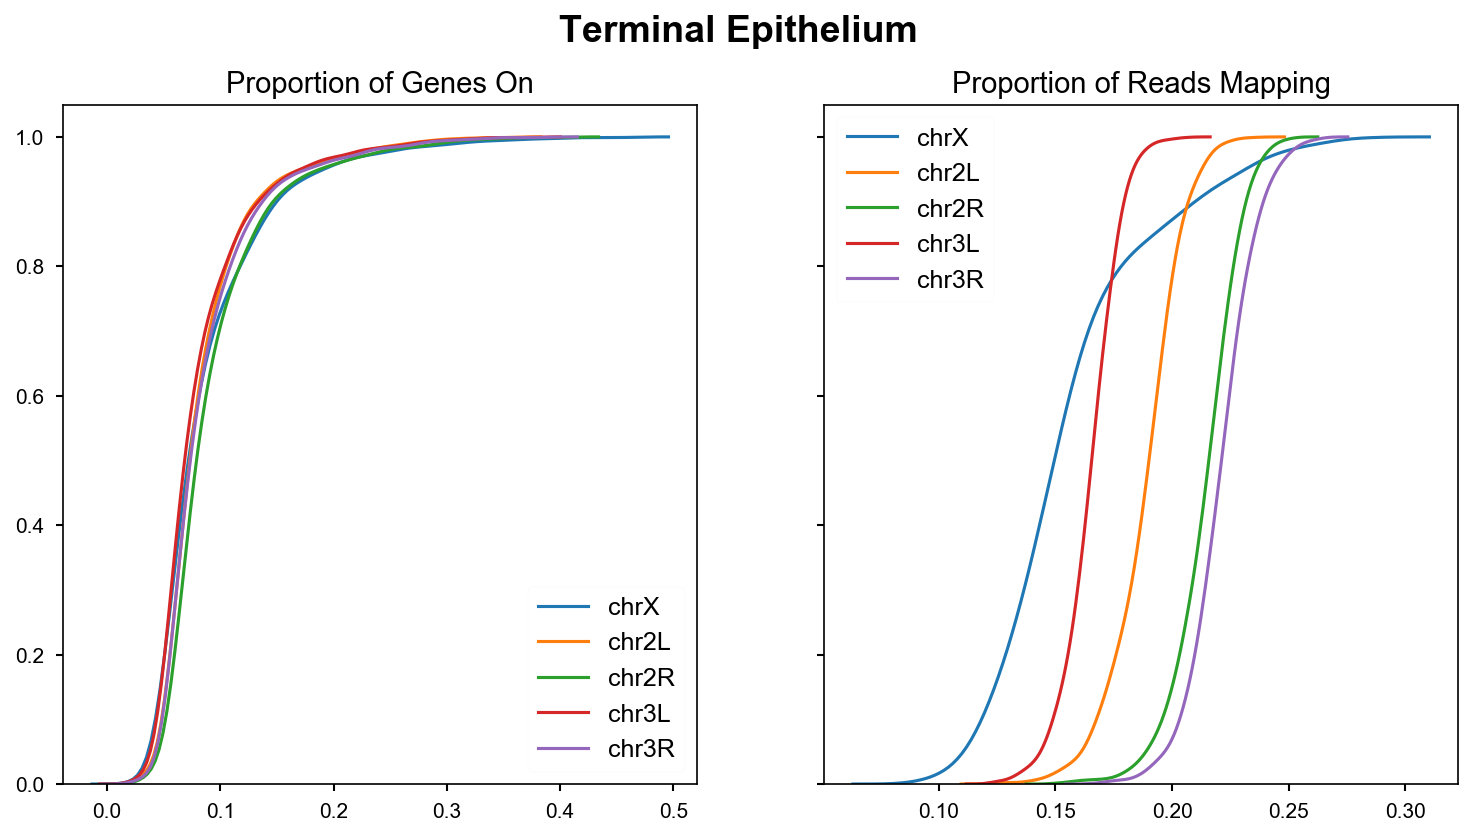

In [107]:
_clus = 'Terminal Epithelium'
res = calc_ratios(_clus)
plot_props(res, _clus)

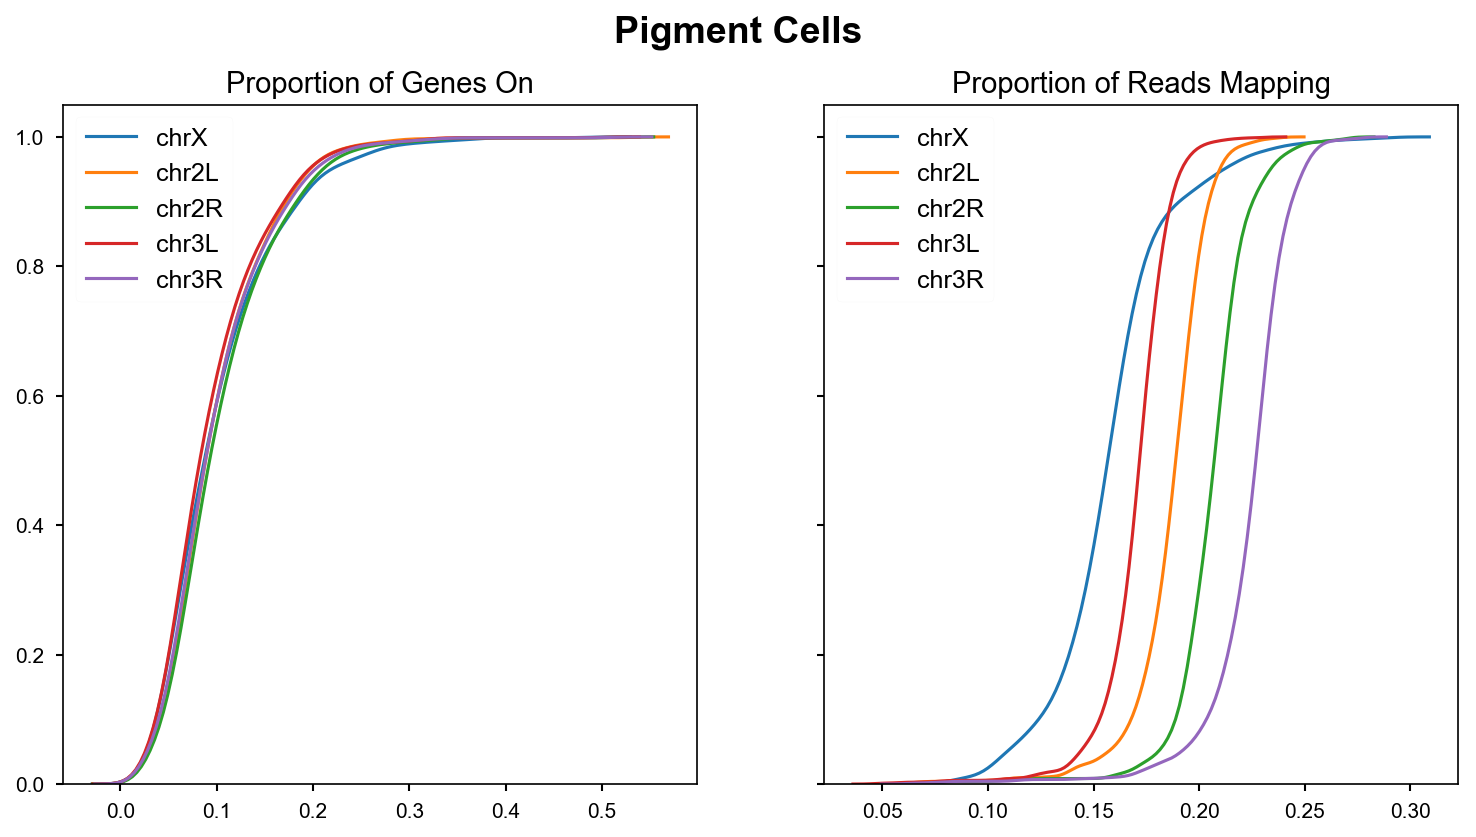

In [108]:
_clus = 'Pigment Cells'
res = calc_ratios(_clus)
plot_props(res, _clus)

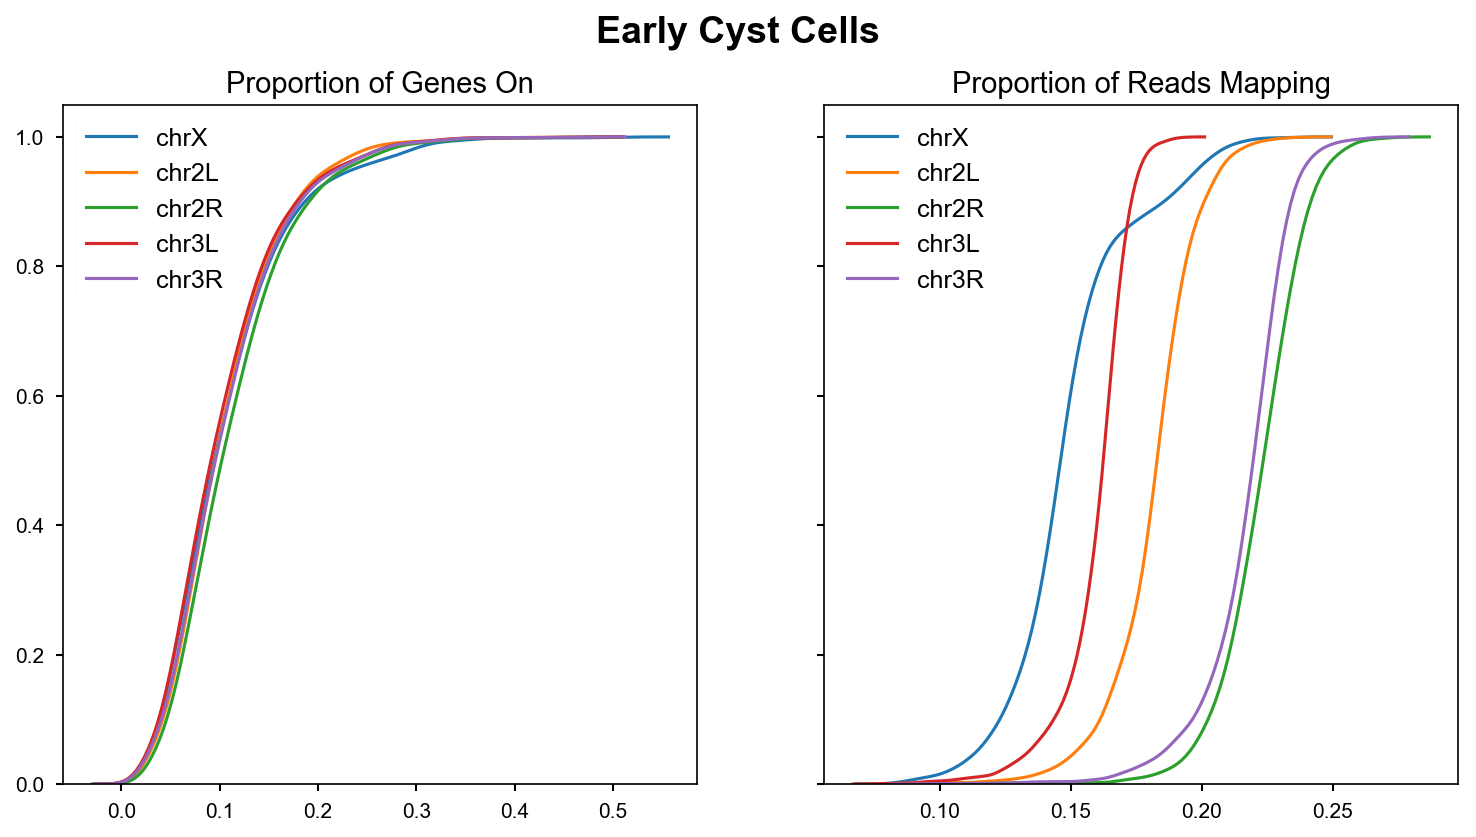

In [109]:
_clus = 'Early Cyst Cells'
res = calc_ratios(_clus)
plot_props(res, _clus)

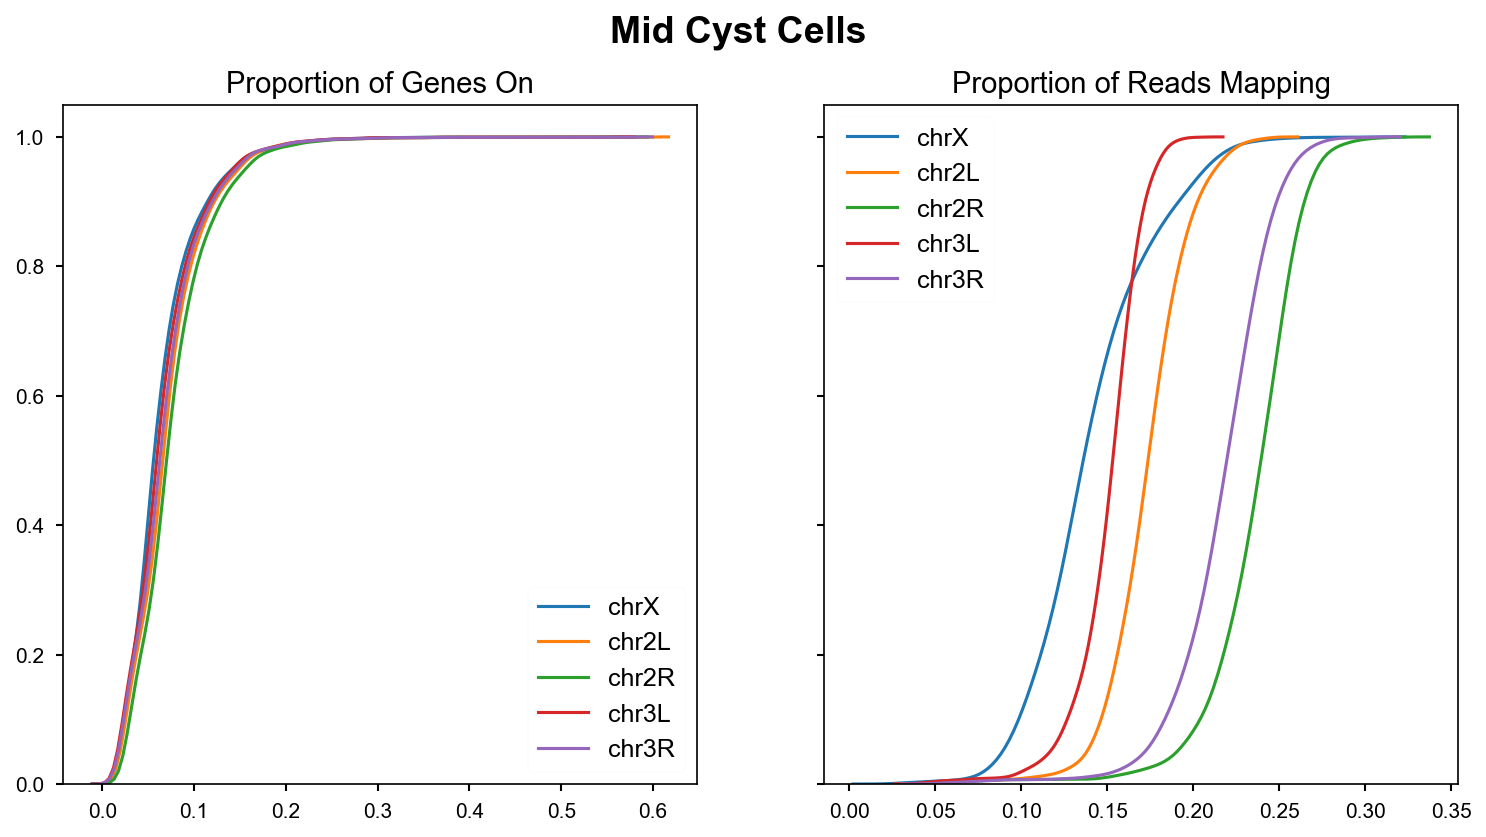

In [110]:
_clus = 'Mid Cyst Cells'
res = calc_ratios(_clus)
plot_props(res, _clus)

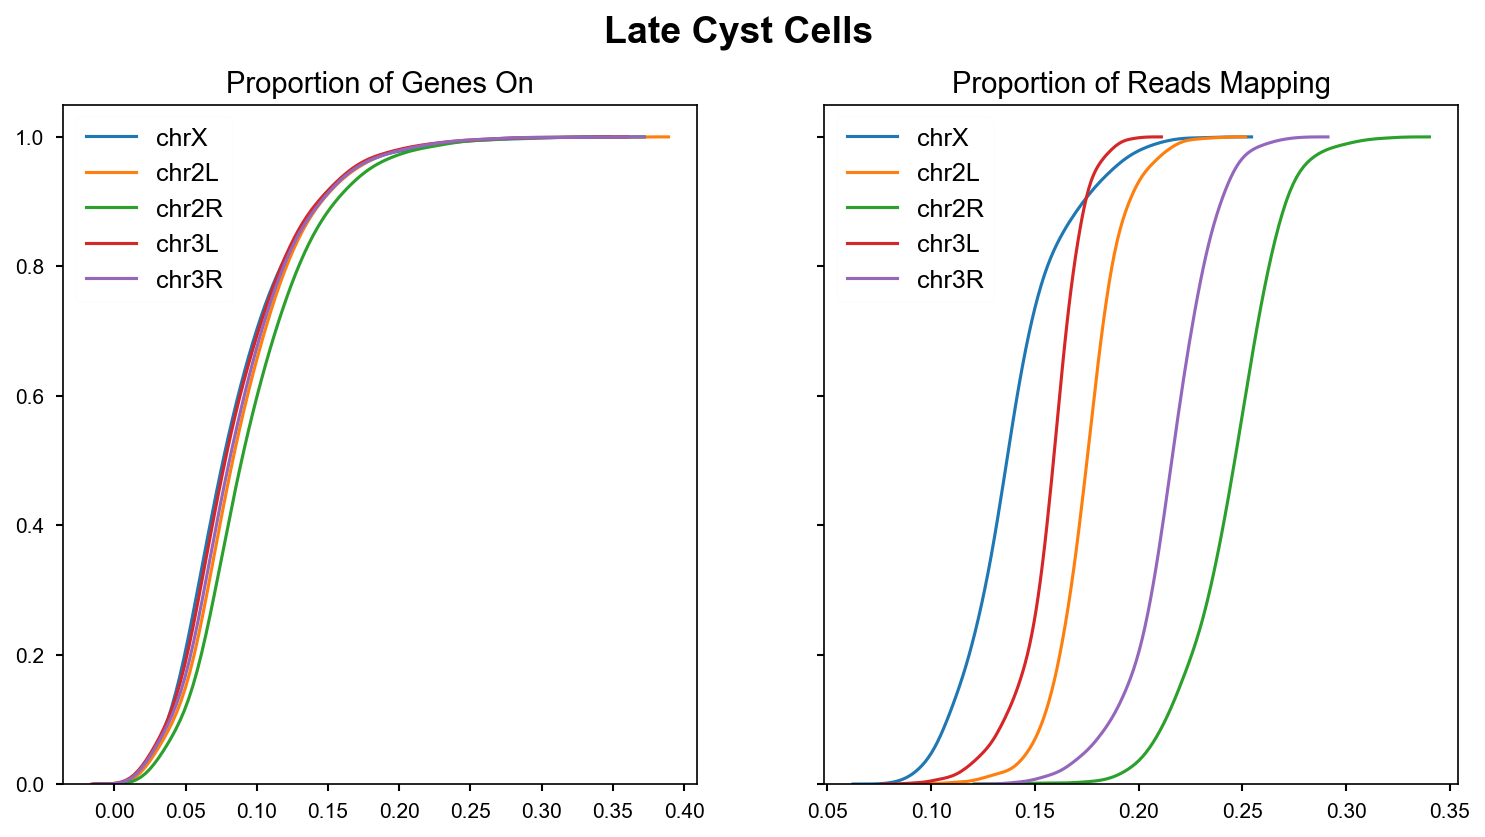

In [111]:
_clus = 'Late Cyst Cells'
res = calc_ratios(_clus)
plot_props(res, _clus)

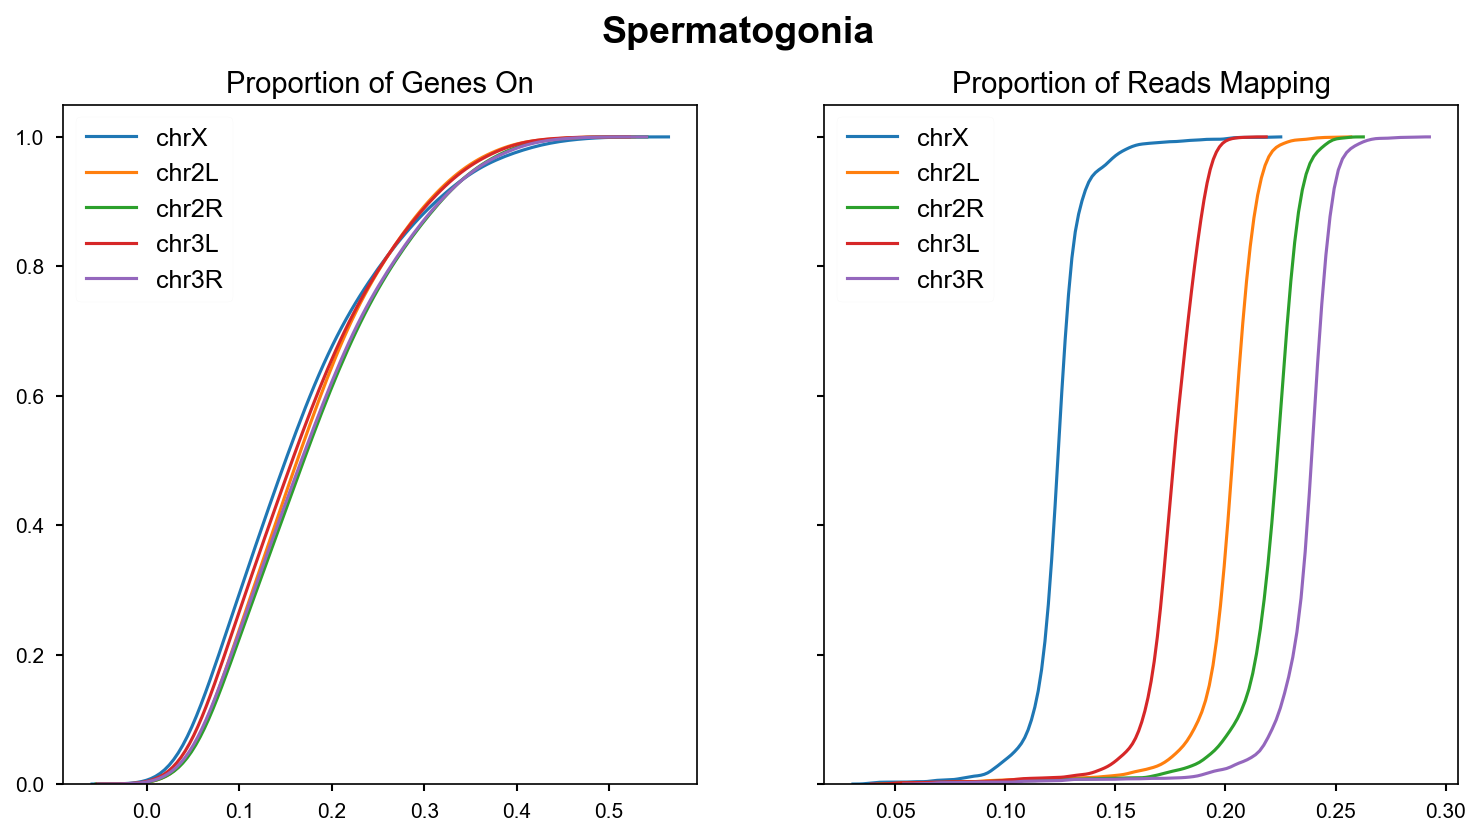

In [112]:
_clus = 'Spermatogonia'
res = calc_ratios(_clus)
plot_props(res, _clus)

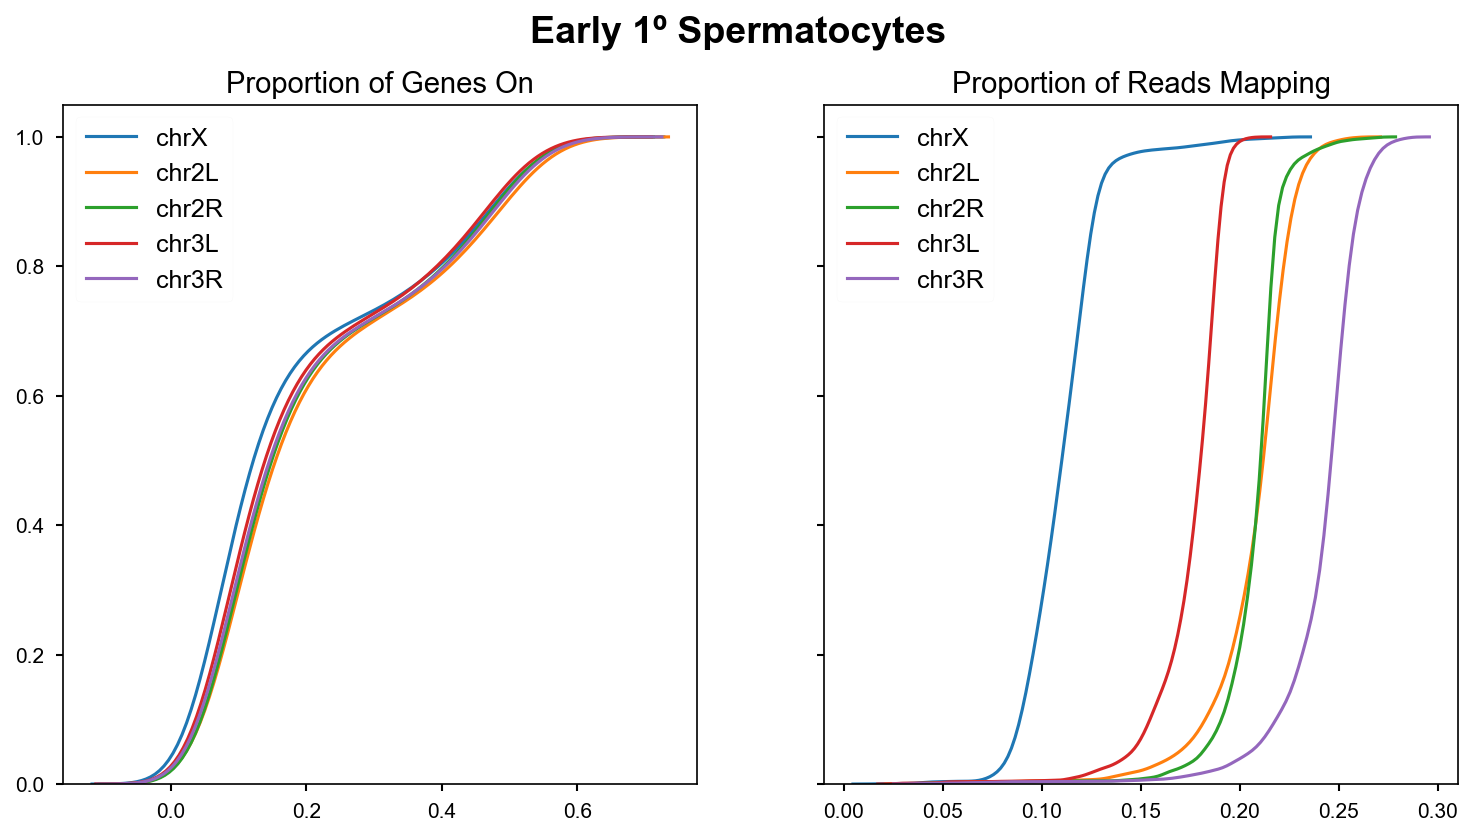

In [101]:
_clus = 'Early 1º Spermatocytes'
res = calc_ratios(_clus)
plot_props(res, _clus)

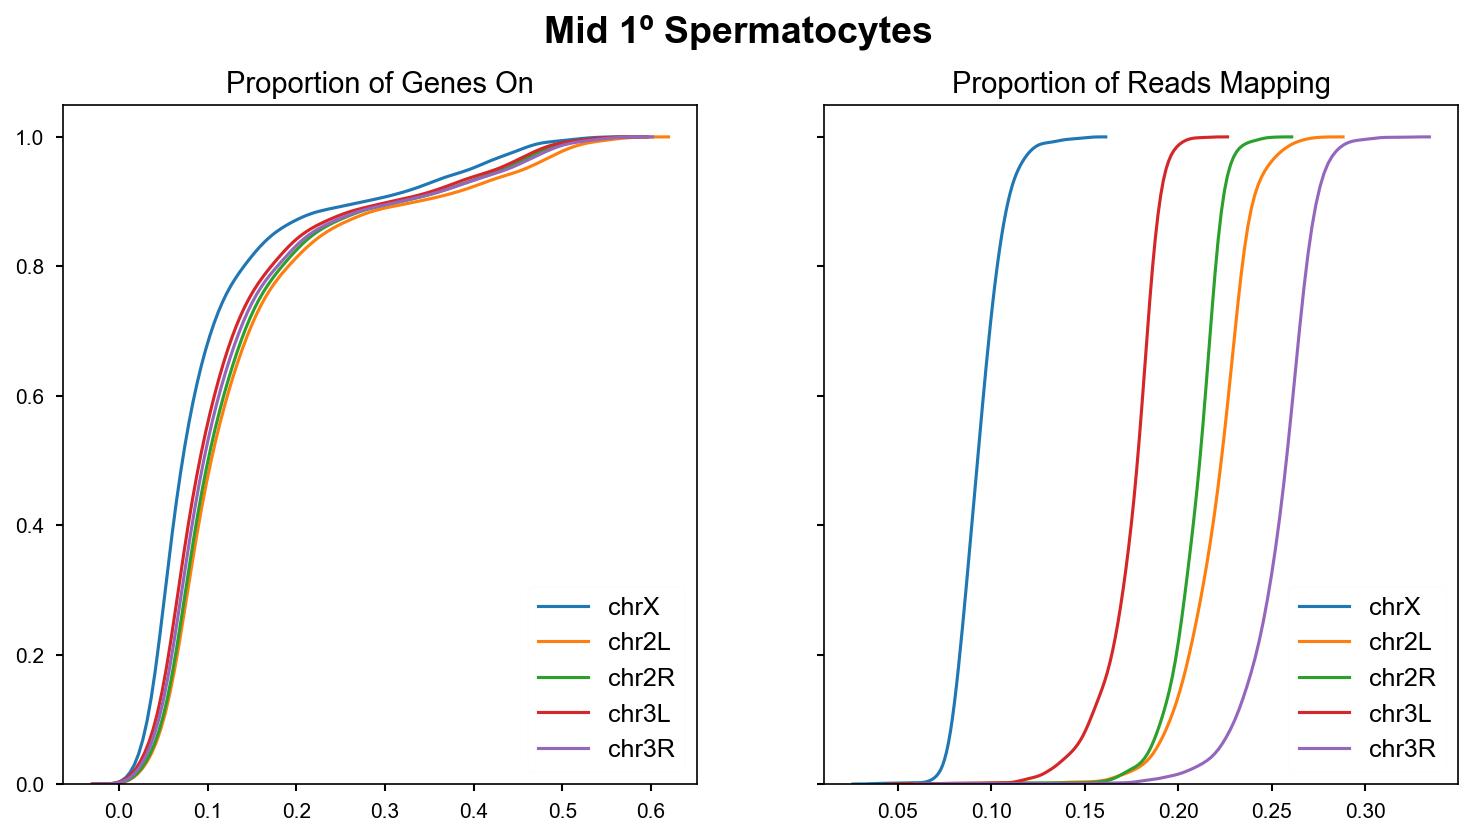

In [102]:
_clus = 'Mid 1º Spermatocytes'
res = calc_ratios(_clus)
plot_props(res, _clus)

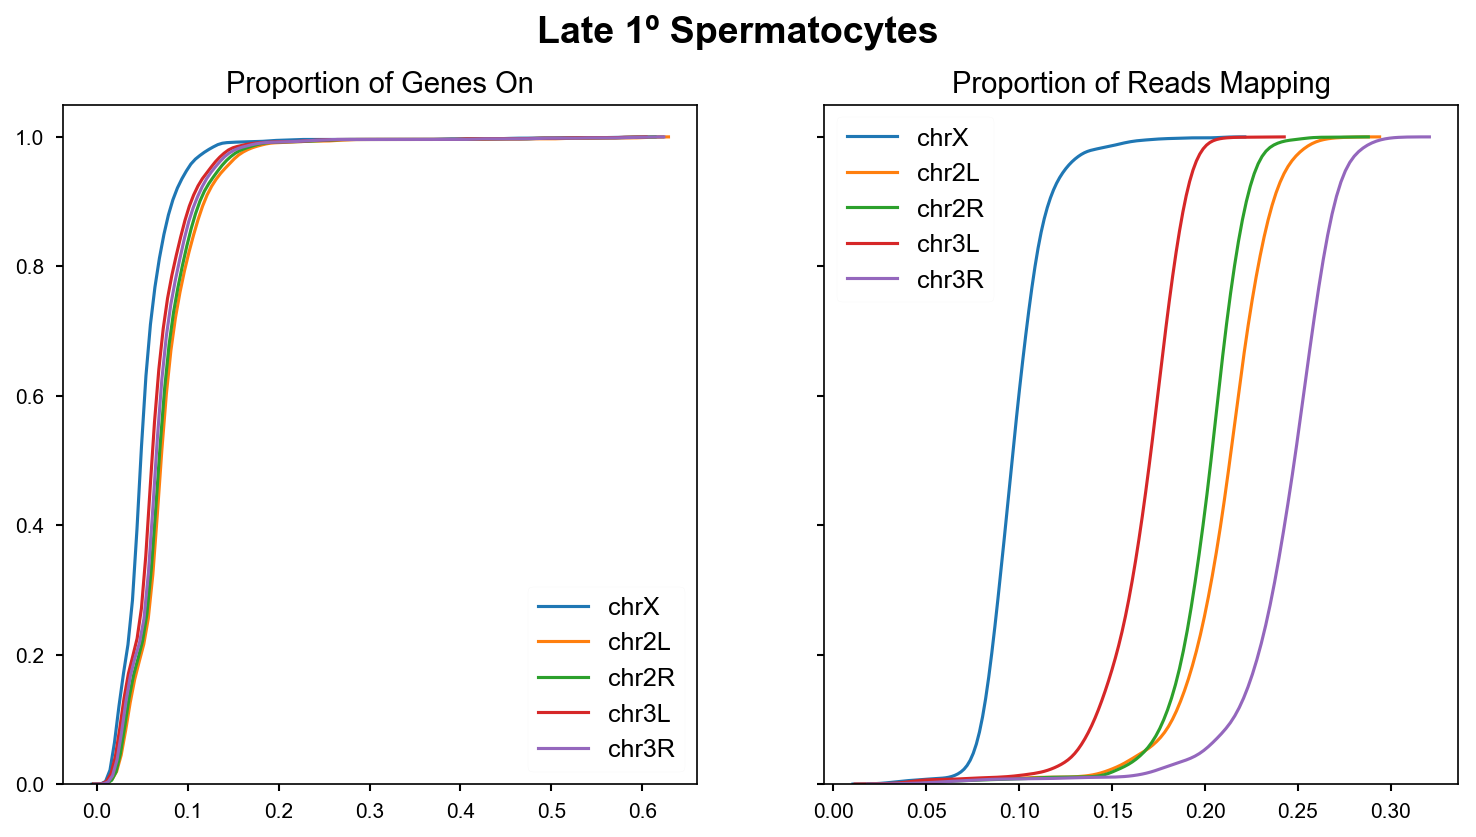

In [103]:
_clus = 'Late 1º Spermatocytes'
res = calc_ratios(_clus)
plot_props(res, _clus)

In [207]:
from scipy.stats import ks_2samp

In [209]:
ks_2samp?

Signature: ks_2samp(data1, data2)
Docstring:
Computes the Kolmogorov-Smirnov statistic on 2 samples.

This is a two-sided test for the null hypothesis that 2 independent samples
are drawn from the same continuous distribution.

Parameters
----------
data1, data2 : sequence of 1-D ndarrays
    two arrays of sample observations assumed to be drawn from a continuous
    distribution, sample sizes can be different

Returns
-------
statistic : float
    KS statistic
pvalue : float
    two-tailed p-value

Notes
-----
This tests whether 2 samples are drawn from the same distribution. Note
that, like in the case of the one-sample K-S test, the distribution is
assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented.
The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot
reject the hypothesis that the distributions of the two samples
are the same.

Examples
--------
>>> from 

In [215]:
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    
    return perm_sample_1, perm_sample_2


def decision(data1, data2):
    #np.sum(np.array(data1) < np.array(data2)) / len(data1)
    stat, _ = ks_2samp(data1, data2)
    return stat


def draw_perm_reps(data1, data2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates


def permutation_test(cluster_name):
    ratios = calc_ratios(cluster_name)
    dat = ratios.query('chrom == ["chrX", "chr3L"]')['prop_on'].to_frame().reset_index().drop('variable_0', axis=1)

    chr3L = dat.query('chrom == "chr3L"').prop_on.values
    chrX = dat.query('chrom == "chrX"').prop_on.values

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
    
    # Plot CDF with perms
    sns.kdeplot(chr3L, cumulative=True, label='chr3L', ax=ax1, lw=3)
    sns.kdeplot(chrX, cumulative=True, label='chrX', ax=ax1, lw=3)
    ax1.set_xlim(0, .3)

    for i in range(1_0):
        x_perm, _ = permutation_sample(chrX, chr3L)
        sns.kdeplot(x_perm, cumulative=True, label='', color='r', lw=1, alpha=.2, ax=ax1)

    # Permutation test
    obs = decision(chrX, chr3L)
    reps = draw_perm_reps(chrX, chr3L, func=decision, size=1_000_000)
    sns.distplot(reps, ax=ax2, label='permuted')
    ax2.axvline(obs, ls=':', color='r', label='observed')
    ax2.legend()
    
    p_value = np.sum(reps >= obs) / len(reps)
    
    return p_value

0.42376399999999997

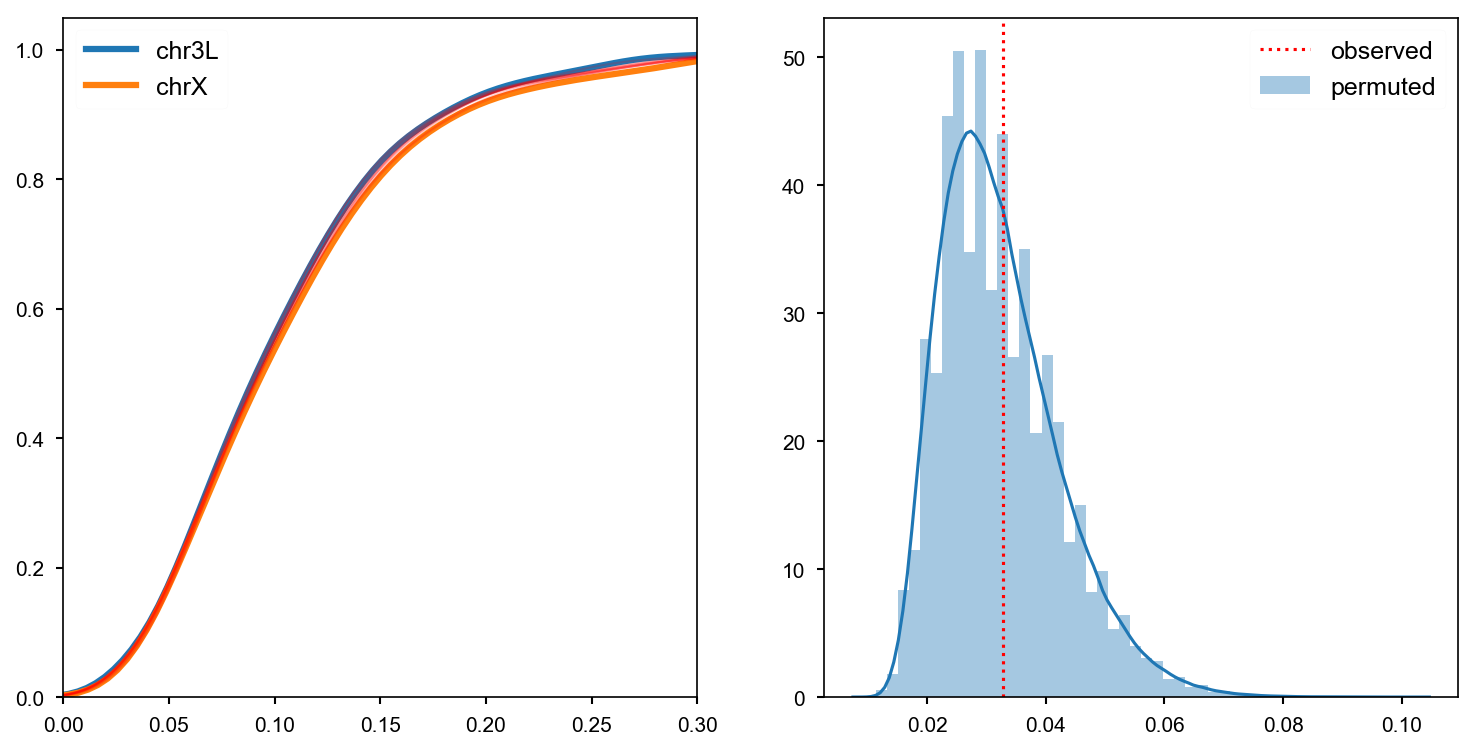

In [216]:
_clus = 'Early Cyst Cells'
permutation_test(_clus)

0.233902

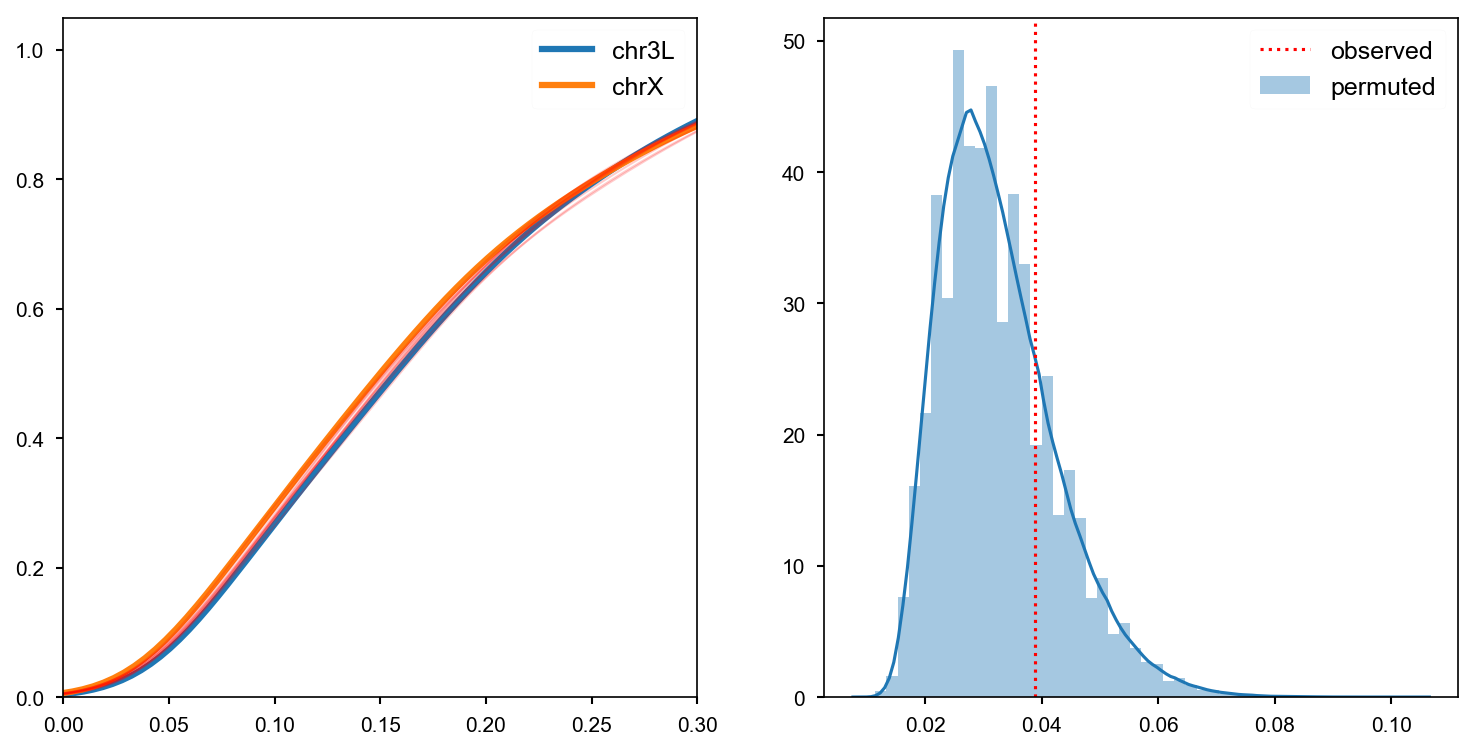

In [217]:
_clus = 'Spermatogonia'
permutation_test(_clus)

6.9999999999999999e-06

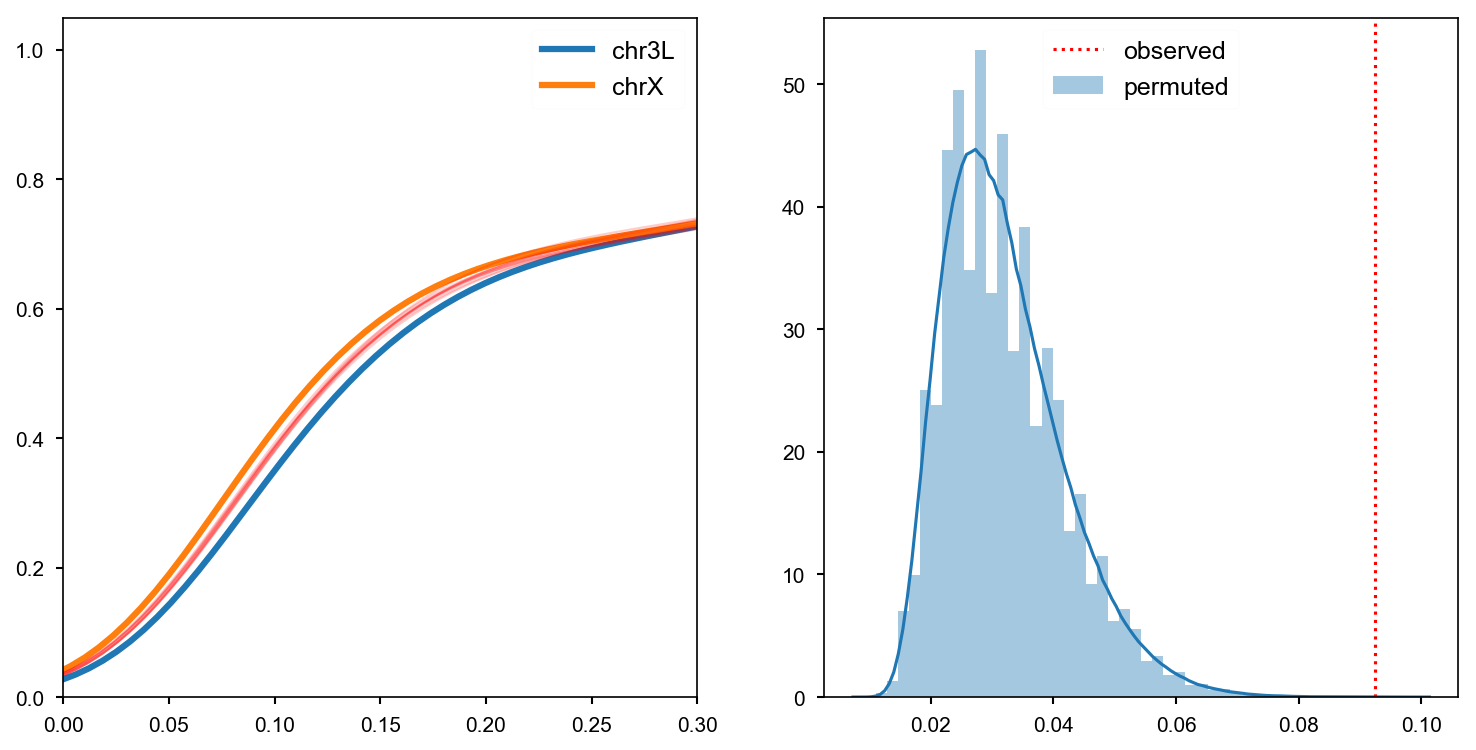

In [218]:
_clus = 'Early 1º Spermatocytes'
permutation_test(_clus)

0.0

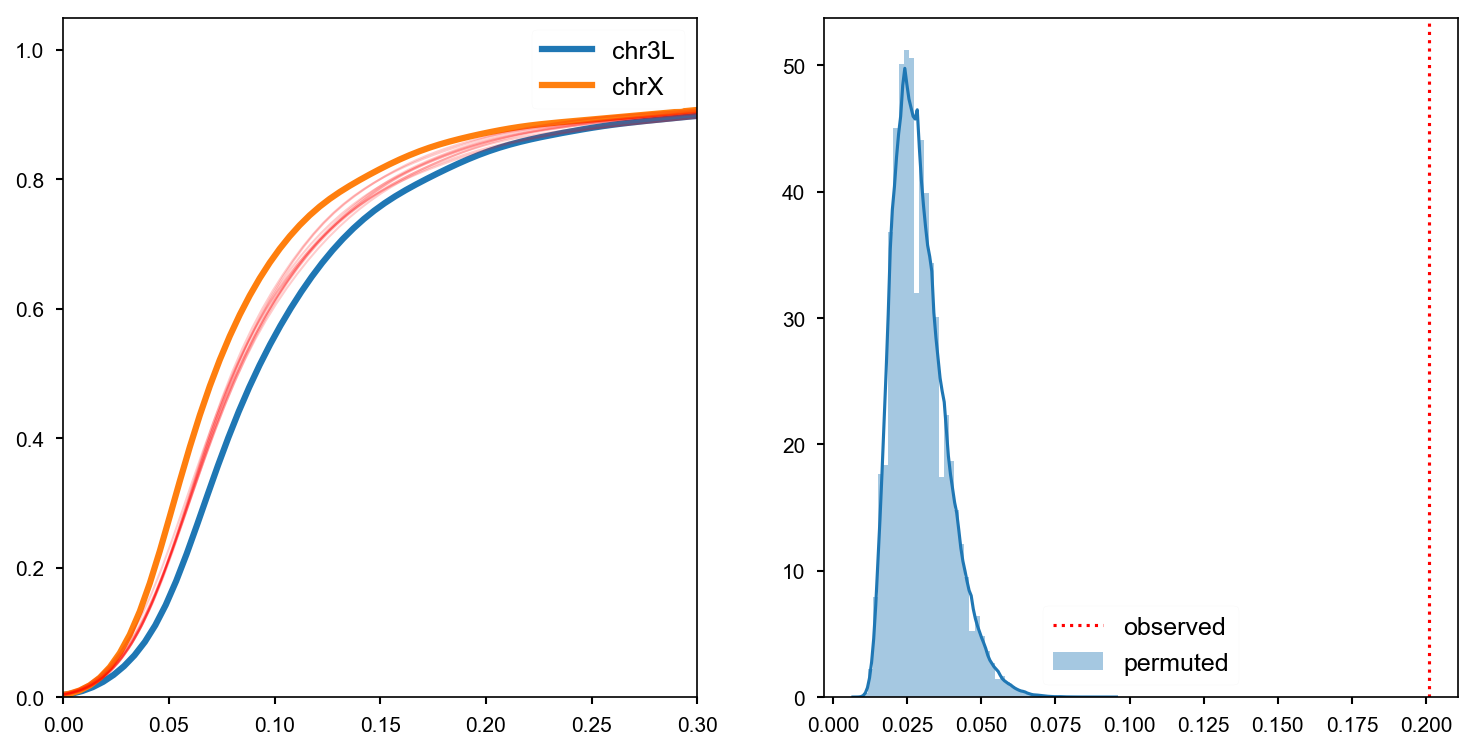

In [219]:
_clus = 'Mid 1º Spermatocytes'
permutation_test(_clus)

0.0

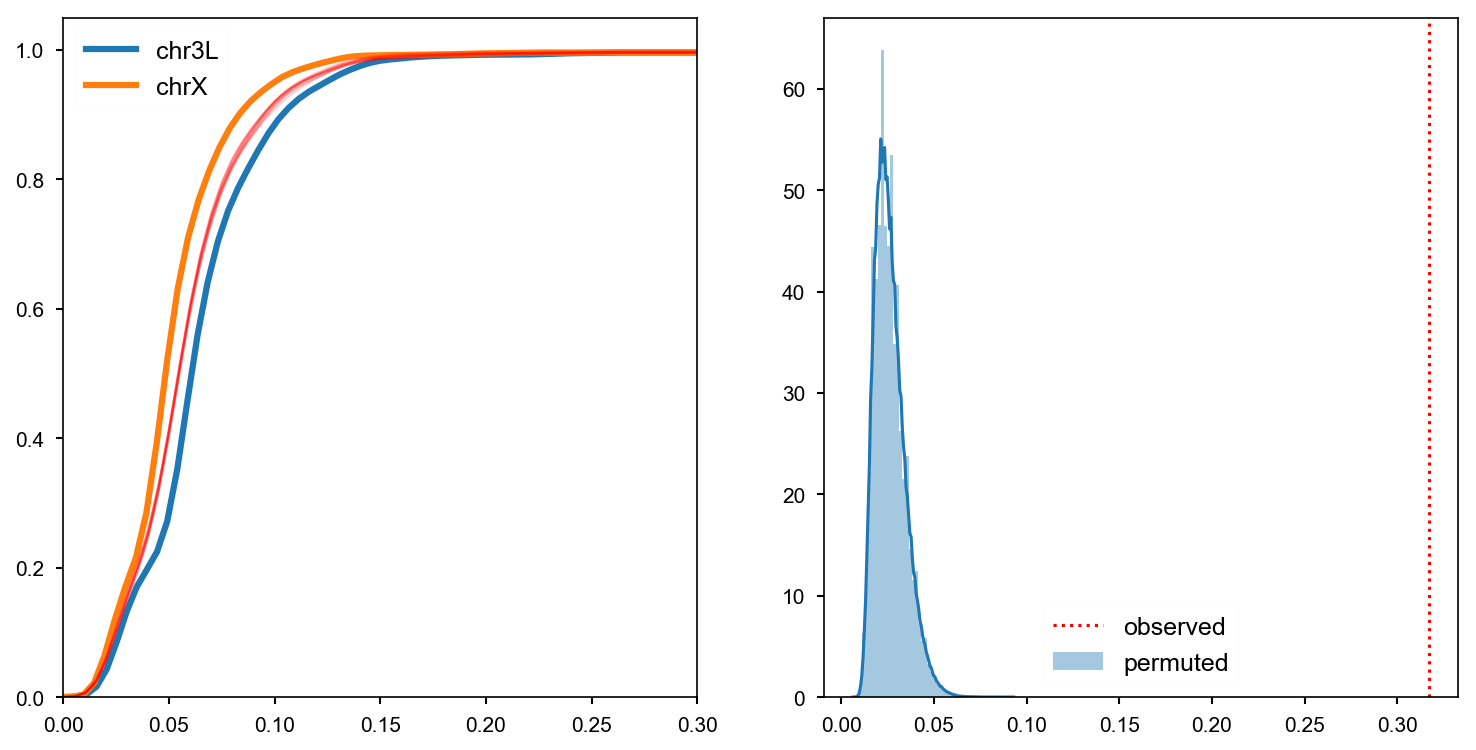

In [220]:
_clus = 'Late 1º Spermatocytes'
permutation_test(_clus)